In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Select model


        About: 

        SICRDq model 

        Some unknown I and known C, both go to recovered and death 

        I and C have same leak to r and d but different to total infected Z
        
S: susceptible
I: infected
C: identified cases
R: recovered
D: dead


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


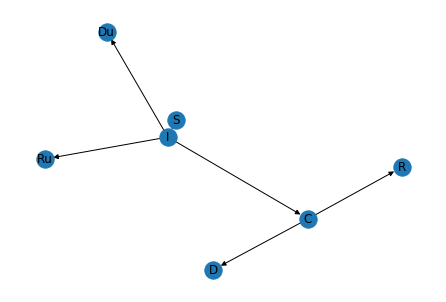

In [3]:
import MBS_epidemic_concentration_models as models
model = models.model_sicrq()
model.plotnetwork()

## Compile

In [4]:
stanrunmodel = pystan.StanModel(model_code=model.stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_746e56acadc1e1d32fead2b7c7fa9578 NOW.


# Load data from JHU



In [5]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)




## Make JHU ROI DF

### Enter country 

In [6]:
#Austria,Belgium,Denmark,France,Germany,Italy,Norway,Spain,Sweden,Switzerland,United Kingdom
roi = "Italy"

t0 assumed to be: day 29


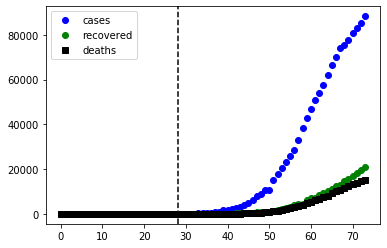

In [7]:
dfc2 = dfc.loc[(dfc['Country/Region']==roi)&(pd.isnull(dfc['Province/State']))]
dfd2 = dfd.loc[(dfd['Country/Region']==roi)&(pd.isnull(dfd['Province/State']))]
dfr2 = dfr.loc[(dfr['Country/Region']==roi)&(pd.isnull(dfr['Province/State']))]


DF = df = pd.DataFrame(columns=['date','cases','recovered','deaths'])

dates = dfc.columns[4:].values

for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'recovered':dfr2[dates[i]].values[0],
                         'deaths':dfd2[dates[i]].values[0]})


pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 6440000

t0 = np.where(DF["cases"].values>5)[0][0] - 1# estimated day of first exposure? Need to make this a parameter
model.stan_data['t0'] = t0-1
print("t0 assumed to be: day "+str(t0))
plt.plot(DF["cases"],'bo', label="cases")
plt.plot(DF["recovered"],'go',label="recovered")
plt.plot(DF["deaths"],'ks',label="deaths")

plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed")
plt.legend()


## Format JHU ROI data for Stan

In [8]:
#truncate time series from t0 on (initial is t0-1)
model.stan_data['ts'] = np.arange(t0,len(dates))  
model.stan_data['y'] = (DF[['cases','recovered','deaths']].to_numpy()).astype(int)[t0:,:]
model.stan_data['n_obs'] = len(dates) - t0

### Enter population manually

In [9]:
model.stan_data['n_pop'] = pop[roi] 
model.stan_data['n_scale'] = 10000000


### Print data for Stan 

In [10]:
print(model.stan_data)

{'n_theta': 6, 'n_difeq': 5, 'n_ostates': 3, 't0': 28, 'ts': array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]), 'y': array([[    3,     0,     0],
       [   19,     0,     1],
       [   59,     1,     2],
       [  150,     2,     3],
       [  221,     1,     7],
       [  311,     1,    10],
       [  438,     3,    12],
       [  593,    45,    17],
       [  821,    46,    21],
       [ 1053,    46,    29],
       [ 1577,    83,    34],
       [ 1835,   149,    52],
       [ 2263,   160,    79],
       [ 2706,   276,   107],
       [ 3296,   414,   148],
       [ 3916,   523,   197],
       [ 5061,   589,   233],
       [ 6387,   622,   366],
       [ 7985,   724,   463],
       [ 8794,   724,   631],
       [10590,  1045,   827],
       [10590,  1045,   827],
       [14955,  1439,  1266],
       [17750,  1966,  1441],
       [206

# Load England School 1978 Influenza data 

In [11]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [12]:
# Feed in some feasible initial values to start from

# init_par = [{'theta':[0.25,0.01,0.01,0.05,.02],'S0':0.5}] 

if model.stan_data['n_theta'] == 2:
    def init_fun():
        x = {'theta':[np.random.uniform(0,5),np.random.uniform(0.2,0.4)],
              'S0':np.random.uniform()}
        return x
else:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]}
#              [model.stan_data['n_scale']],
#               'S0':1*np.random.uniform()}
#         x = {'theta':[np.random.uniform(), np.random.uniform(),
#                       np.random.uniform(),np.random.uniform(),np.random.uniform()],
#               'S0':1*np.random.uniform()}
        return x

## Fit Stan 

In [13]:
n_chains=8
n_warmups=500
n_iter=10000
n_thin=100

control = {'adapt_delta':0.95}
fit = stanrunmodel.sampling(data = model.stan_data,init = init_fun,control=control, chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)



In [14]:
print(fit)

Inference for Stan model: anon_model_746e56acadc1e1d32fead2b7c7fa9578.
8 chains, each with iter=10000; warmup=500; thin=100; 
post-warmup draws per chain=95, total post-warmup draws=760.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]  8.3e-4  6.3e-5 1.3e-4 6.6e-4 6.6e-4 9.2e-4 9.3e-4 9.4e-4      4   5.01
theta[2]    0.02  3.3e-4 6.8e-4   0.02   0.02   0.02   0.02   0.02      4   4.79
theta[3]    0.01  2.6e-4 5.3e-4   0.01   0.01   0.01   0.01   0.01      4   4.87
theta[4]    0.14    0.06   0.18   0.01   0.03   0.06   0.19   0.52     10   1.36
theta[5]    0.32    0.05    0.1   0.25   0.25   0.25   0.45   0.45      4   5.81
theta[6]   2.3e4  8896.7  1.8e4 1.5e-3   0.03  3.7e4  3.8e4  3.8e4      4   5.24
u[1,1]    2.8e-6  8.9e-7 1.8e-6 4.5e-7 4.5e-7 4.1e-6 4.2e-6 4.3e-6      4   5.13
u[2,1]    5.7e-6  1.9e-6 4.0e-6 6.7e-7 6.7e-7 8.7e-6 9.0e-6 9.1e-6      4   5.15
u[3,1]    9.4e-6  3.2e-6 6.6e-6 1.0e-6 1.0e-6 1.4e-5 1.5e-5 1.5e-5      4   5.17
u[

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12facb110>,
      dtype=object)

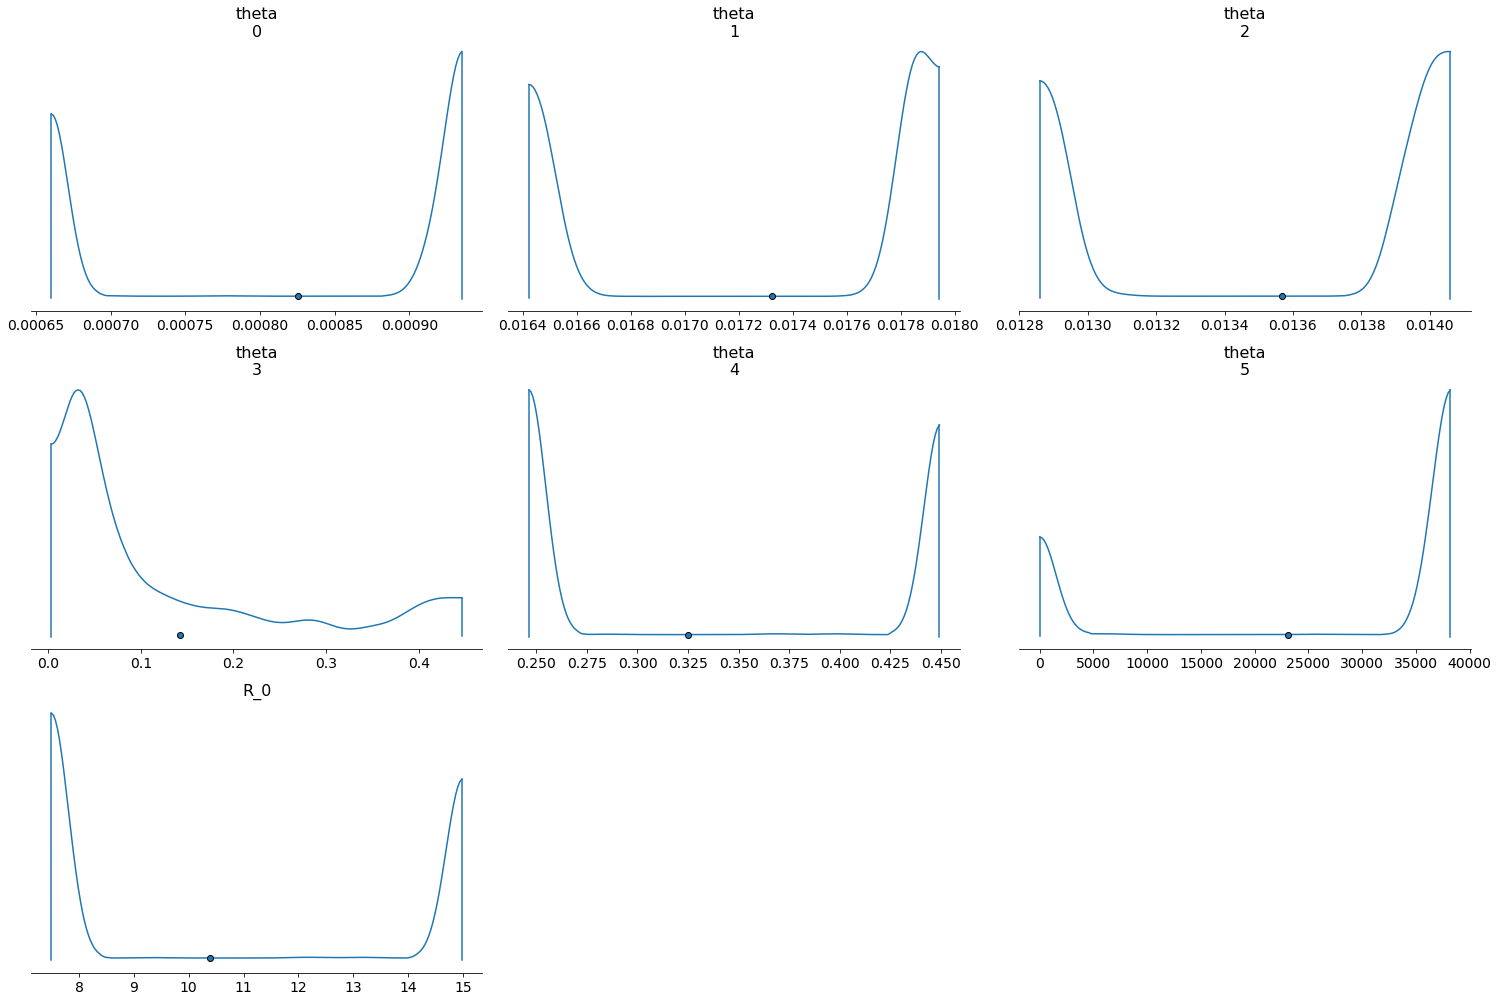

In [15]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])

(760, 45, 5)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12f44c390>,
      dtype=object)

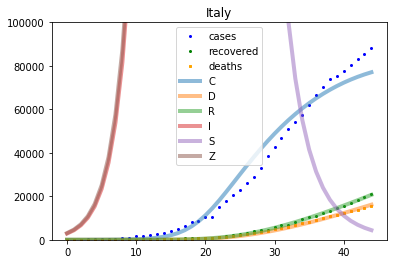

<Figure size 432x288 with 0 Axes>

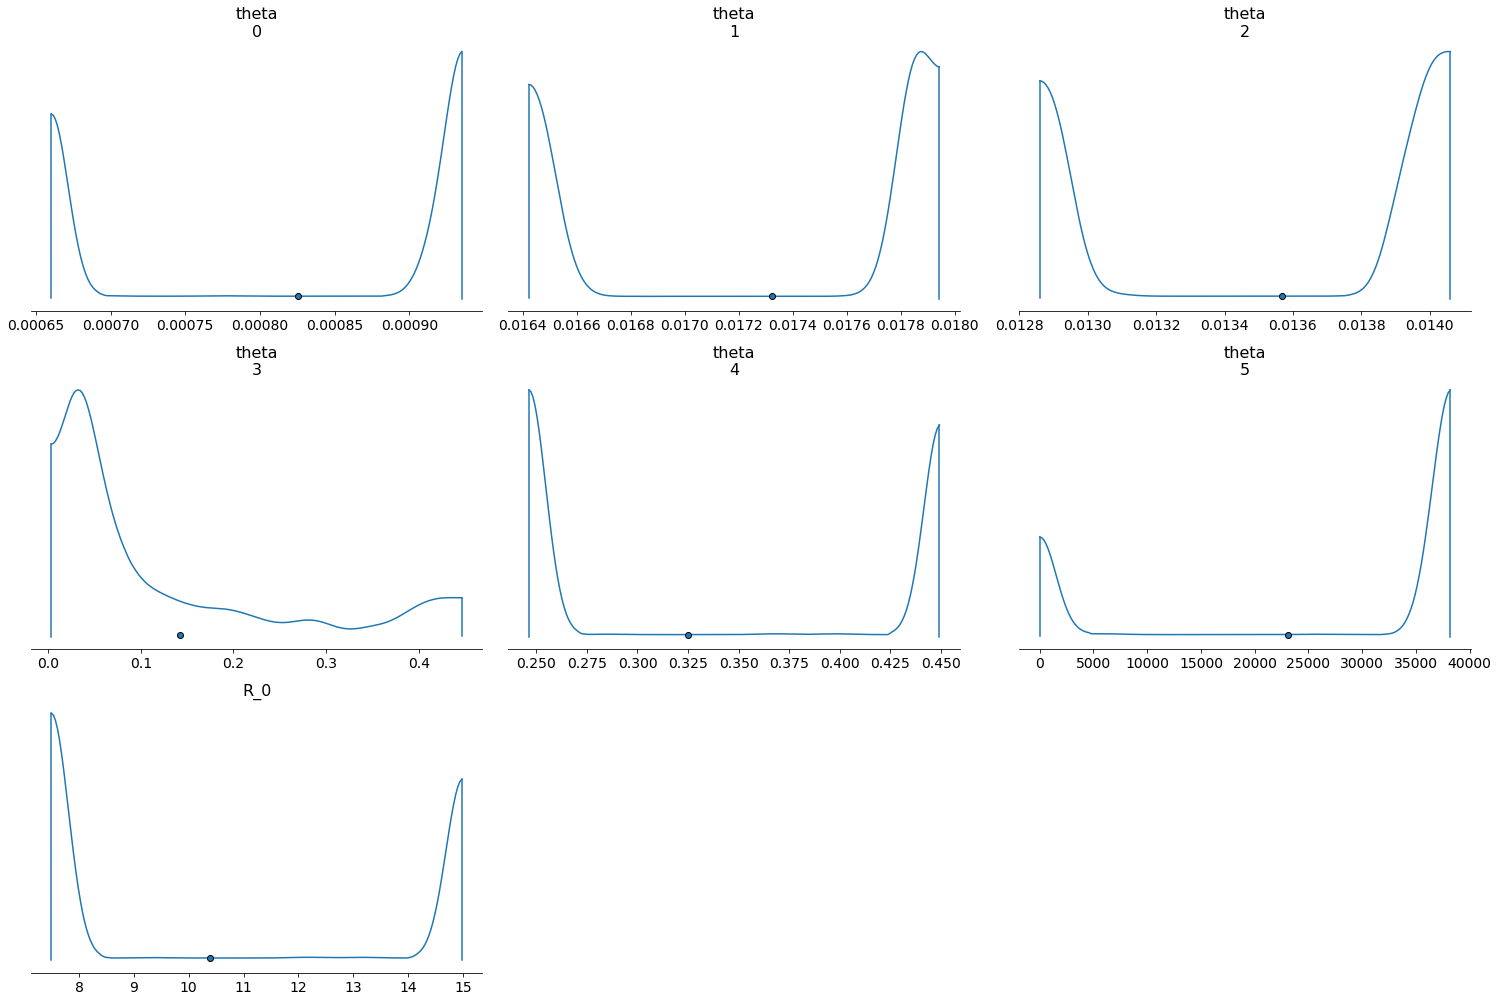

In [16]:
# dir(fit)
# stan_data = az.from_pystan(
#     posterior=fit,
#     posterior_predictive='y_hat',
#     observed_data="y[1,1]")

# print(stan_data)
# # az.plot_ppc(stan_data)

print(np.shape(fit.extract()['u']))
# plt.plot(np.mean(fit.extract()['y_hat'][:,:,1],0),'r', label=r'$\hat{I}$')
# plt.plot(np.mean(fit.extract()['y_hat'][:,:,2],0),'b', label=r'$\hat{R}$')
# plt.legend()
# plt.ylabel('fraction')
# plt.xlabel('days')
# # plt.plot(model.stan_data['y'][:,0],'bo', label="cases")
# # plt.plot(model.stan_data['y'][:,1],'go',label="recovered")

# plt.plot(fit.extract()['u'][-1,:,4],'r', label=r'$\hat{I}$')
# plt.plot(fit.extract()['u'][-1,:,2],'b', label=r'$\hat{R}$')
# plt.legend()
# plt.ylabel('fraction')
# plt.xlabel('days')
# plt.plot(model.stan_data['y'][:,0],'bo', label="cases")
# plt.plot(model.stan_data['y'][:,1],'go',label="recovered")
# plt.subplot(1,2,1)
ms=2 
x = range(len(fit.extract()['u'][-1,:,0]))
plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
plt.plot(x,DF["recovered"][t0:],'go',label="recovered",ms=ms)
plt.plot(x,DF["deaths"][t0:],'s',label="deaths",color='orange',ms=ms)

labels = ['C','D','R','I','S','Z']
lw=4
a = 0.5
for i in range(5):
    plt.plot(model.stan_data['n_scale']*fit.extract()['u'][-1,:,i],label=labels[i],lw=lw,alpha=a)
plt.plot(model.stan_data['n_scale']*(1-fit.extract()['u'][-1,:,4]),label=labels[-1],lw=lw,alpha=a)
plt.legend()
plt.ylim((0,100000))

# plt.subplot(1,2,2)
# tot = DF["cases"][-1:] + DF["recovered"][-1:] + DF["deaths"][-1:]

# plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed")
plt.legend()
plt.title(roi)
plt.figure()
# plt.plot(fit.extract()['lp__'])
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13205b390>,
      dtype=object)

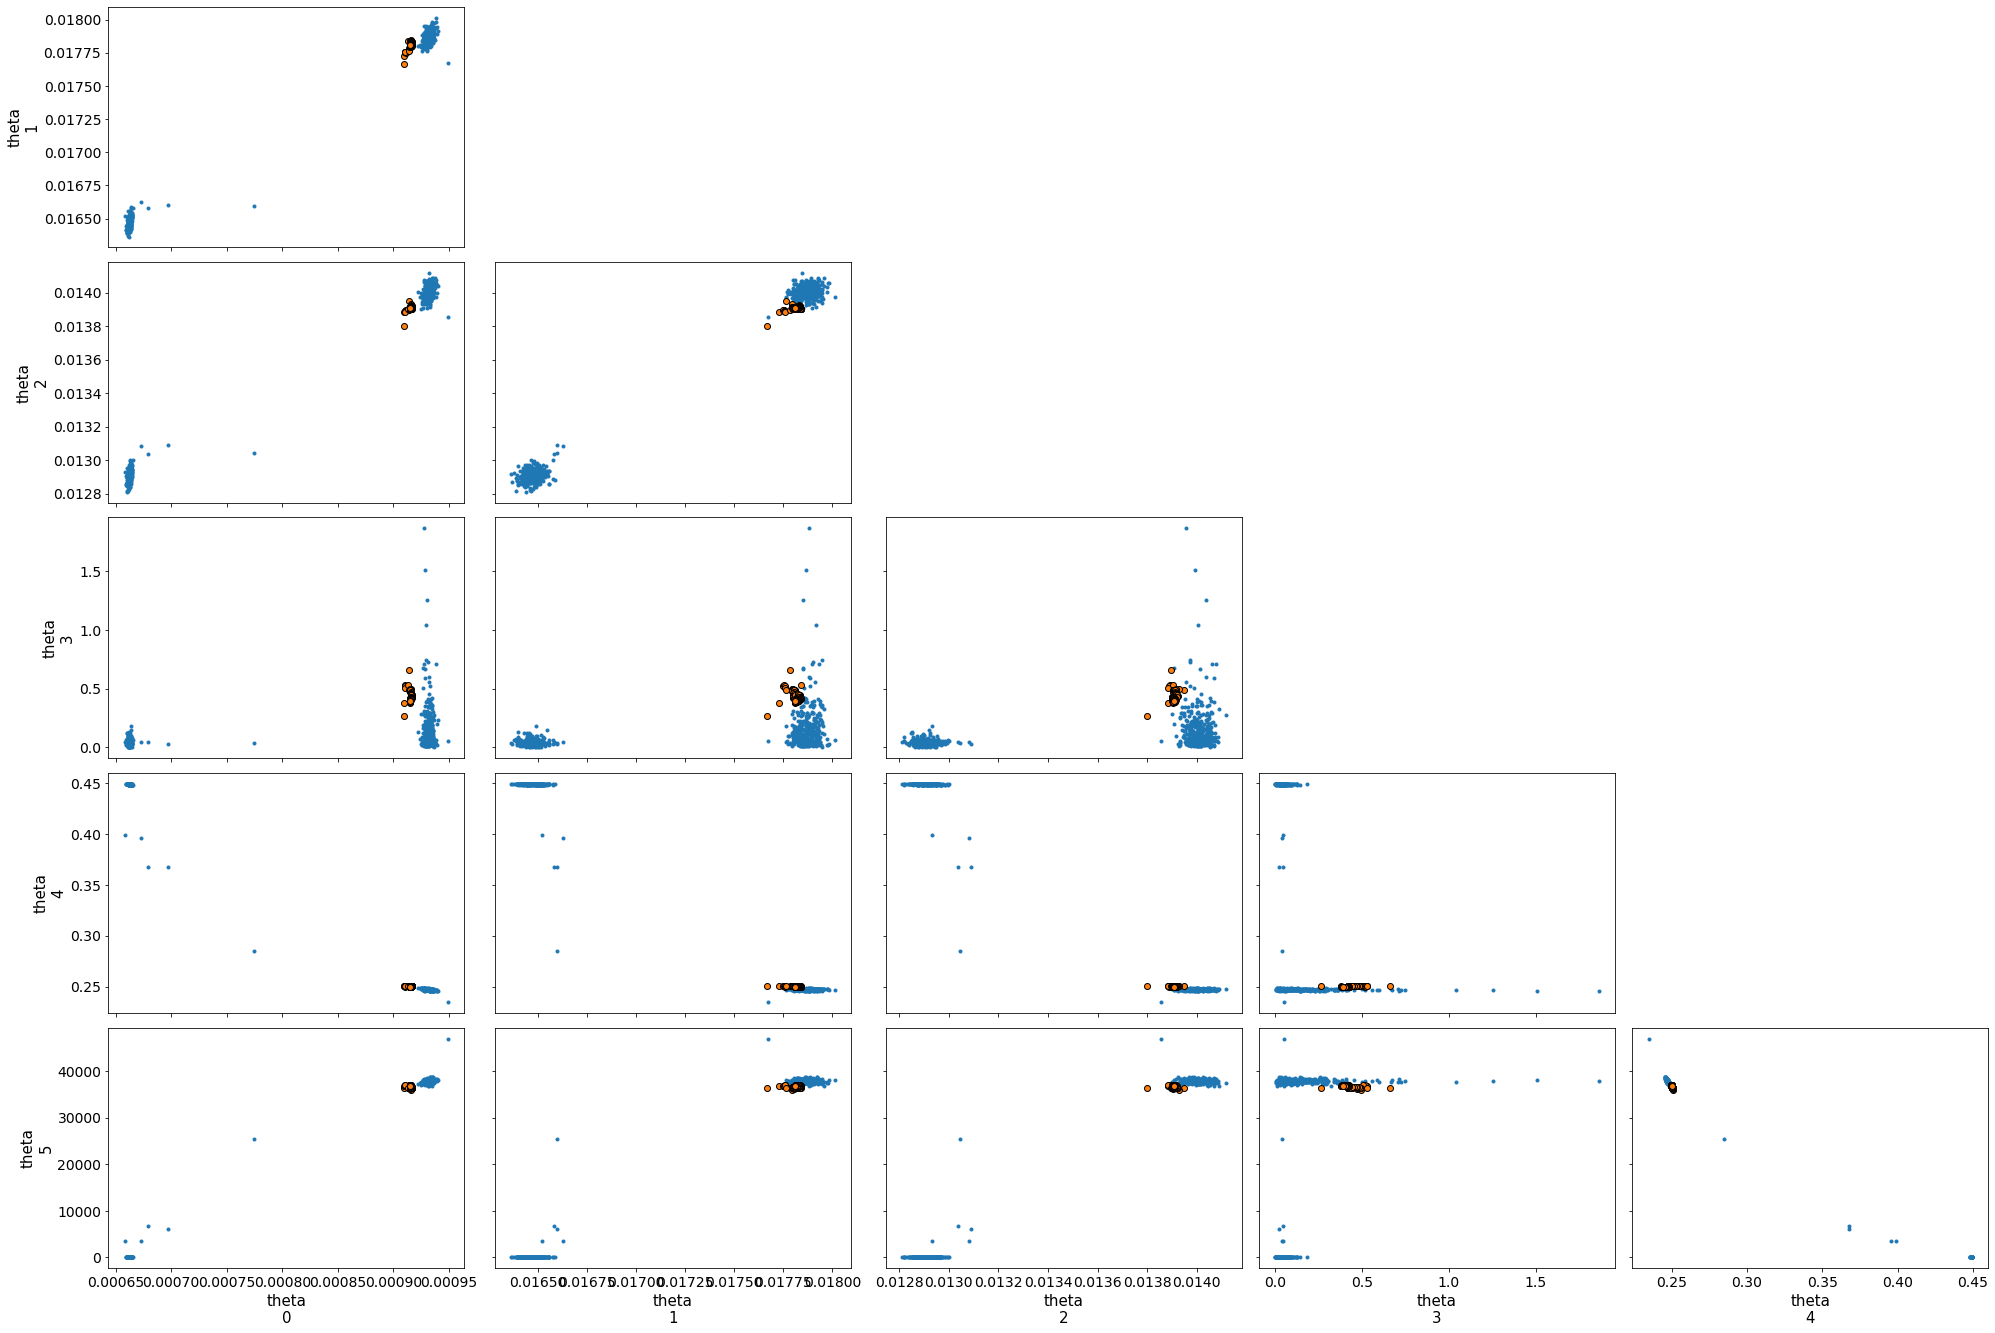

In [17]:
az.plot_pair(fit,var_names=["theta"], divergences=True)